# Initialisation and setup

In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd

import sys
import os
import matplotlib.pyplot as plt
import time

sys.path.append('../')

import geobin_py as gb
from utils import plot_hyperplane

In [2]:
import pandas as pd
import torch
import re

def csv_to_state_dict(filename):
    df = pd.read_csv(filename)
    state_dict = {}
    
    # Group by layer and type (weight vs bias)
    for (layer, p_type), group in df.groupby(['layer', 'type']):
        # Parse coordinates to find max dimensions
        coords = group['coord'].apply(lambda x: [int(d) for d in re.findall(r'\d+', x)]).tolist()
        values = group['value'].values
        
        # Determine shape (max_index + 1)
        max_dims = np.max(coords, axis=0) + 1
        
        # Create empty tensor and fill it
        tensor = torch.zeros(tuple(max_dims))
        for coord, val in zip(coords, values):
            if len(coord) == 2:
                tensor[coord[0], coord[1]] = val
            else:
                tensor[coord[0]] = val
        
        state_dict[f"{layer}.{p_type}"] = tensor
        
    return state_dict

# Usage
state = csv_to_state_dict("dummy_weights.csv")

In [3]:
W, b = gb.find_hyperplanes(state)

In [4]:
x0 = np.array([[-2.5],[-5]])
x0.shape

(2, 1)

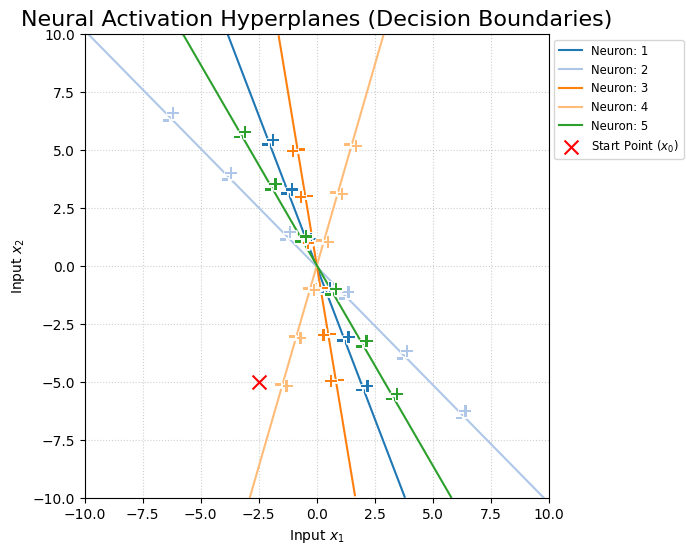

In [5]:
from itertools import cycle
# Using tab20 to get 20 distinct colors before repeating
color_pool = cycle(plt.cm.tab20.colors)
fig, ax = plt.subplots(figsize=(7, 7))
fac = 10
# Iterate through weights and biases to plot hyperplanes
for n, (we, be) in enumerate(zip(W[0], b[0])):
    # Get a real color from the cycle (Crucial fix)
    current_color = next(color_pool)
    
    # We pass a higher offset (e.g., 4.0) because the coordinate space is 200 units wide
    plot_hyperplane(ax, we, be, color=current_color, label=f"Neuron: {n+1}", offset=fac/50, fac=fac)

# Mark the specific point x0
ax.scatter(x0[0], x0[1], marker="x", color="red", s=100, label="Start Point ($x_0$)", zorder=5)

# Formatting the plot
ax.set_xlim(-fac, fac)
ax.set_ylim(-fac, fac)
ax.set_aspect('equal')
ax.grid(True, linestyle=':', alpha=0.6)

# Move legend outside if there are many neurons
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize='small', ncol=1)

plt.title("Neural Activation Hyperplanes (Decision Boundaries)", fontsize=16)
plt.xlabel("Input $x_1$")
plt.ylabel("Input $x_2$")
plt.tight_layout()
plt.show()

# Activation pattern